In [23]:
using PyCall
using MXNet
using MLDataPattern
using Polyhedra
using CDDLib
using Plots
using JuMP
using Gurobi
using ProgressMeter
pyplot()

Plots.PyPlotBackend()

In [15]:
push!(pyimport("sys")["path"], joinpath(pwd(), "py-mpc"));

In [16]:
@pyimport pympc.geometry as geometry
@pyimport pympc.control as control
@pyimport pympc.dynamical_systems as dynamical_systems
@pyimport pympc.plot as mpcplot
@pyimport scipy.spatial as spatial

In [17]:
include("piecewise.jl")
include("mpc.jl")
# include("learning.jl")

function JuMP.solve(mm::MPC.MPCModel, x0::Vector)
    JuMP.fix.(mm.x[:, 1], x0)
    status = solve(mm.model; suppress_warnings=true)
    utraj = pf.PiecewiseFunction(mm.times, [t -> getvalue.(mm.u[:, j]) for j in 1:size(mm.u, 2)])
    status, utraj
end

function MPC.output(controller::PiecewiseFunctions.PiecewiseFunction, t, state) 
    controller(t)
end

In [18]:
mass = 1.
l = 1.
g = 10.
N = 4
A = [0. 1.;
     g/l 0.]
B = [0 1/(mass*l^2.)]'
Δt = .1
sys = MPC.discretize(MPC.CTLinearSytstem(A, B), Δt)

x_max = [pi/6, pi/20/(N*Δt)]
x_min = -x_max
u_max = [mass*g*l*pi/8.]
u_min = -u_max
times = 0:Δt:N*Δt

x0 = [0.1, 0.05]
mm = MPC.MPCModel(sys, N)
setsolver(mm.model, GurobiSolver(OutputFlag=0))
setlowerbound.(mm.u, u_min)
setupperbound.(mm.u, u_max)
setlowerbound.(mm.x[:, 2:end], x_min)
setupperbound.(mm.x[:, 2:end], x_max)
status, utraj = solve(mm, x0)
states = MPC.simulate(sys, utraj, x0, times)
for i in 1:length(states)
    @assert states[i] ≈ getvalue.(mm.x[:, i])
end

mm = MPC.MPCModel(sys, N)
setsolver(mm.model, GurobiSolver(OutputFlag=0))
setlowerbound.(mm.u, u_min)
setupperbound.(mm.u, u_max)
setlowerbound.(mm.x[:, 2:end], x_min)
setupperbound.(mm.x[:, 2:end], x_max)


num_samples = 10000
X = fill(NaN, 2, num_samples)
U = fill(NaN, 1, num_samples)

for i in 1:num_samples
    while true
        x0 = x_min .+ rand(2) .* (x_max .- x_min)
        status, utraj = solve(mm, x0)
        if status == :Optimal
            X[:, i] = x0
            U[:, i] = getvalue.(mm.u[:, 1])
#             push!(samples, Learning.Sample{2, 1}(x0, getvalue.(mm.u[:, 1])))
            break
        end
    end
end

In [19]:
import Nets

In [38]:
reload("Nets")

INFO: Recompiling stale cache file /Users/rdeits/locomotion/explorations/learning-mpc/packages/lib/v0.6/Nets.ji for module Nets.


In [39]:
train_data, test_data = splitobs([(X[:, i], U[:, i]) for i in 1:size(X, 2)], 0.6);

In [75]:
widths = [2, 4, 4, 4, 1]
net = Nets.Net(widths)

sgdopts = Nets.SGDOpts(
    learning_rate=0.1,
    batch_size=100,
    learning_decay=0.98)
nepoch = 60

loss = (params, x, y) -> sum(abs2, y - Nets.predict(net, params, x))

(::#303) (generic function with 1 method)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:04



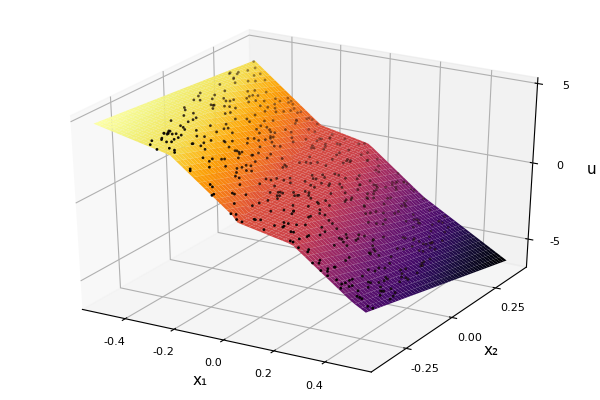

In [76]:
params = 1 * (rand(net) .- 0.5)
losses = Float64[]

@showprogress for i in 1:nepoch
    Nets.sgd!(loss, params, train_data, sgdopts)
    push!(losses, mean(xy -> loss(params, xy[1], xy[2]), test_data))
end


xx = linspace(x_min[1], x_max[1])
yy = linspace(x_min[2], x_max[2])
plt = surface(xx, yy, (x, y) -> Nets.predict(net, params, [x, y])[1], 
legend=nothing,
xlabel="x₁",
ylabel="x₂",
zlabel="u"
)
plot!(plt, [X[1, i] for i in 1:500], [X[2, i] for i in 1:500], [U[1, i] for i in 1:500], markershape=:circle, markersize=1, line=nothing)
plt

In [48]:
gui()

Stacktrace:
 [1] depwarn(::String, ::Symbol) at ./deprecated.jl:64
 [2] Array(::Type{Float64}, ::Int64) at ./deprecated.jl:51
 [3] indices at ./abstractarray.jl:57 [inlined]
 [4] indices1 at ./abstractarray.jl:64 [inlined]
 [5] linearindices at ./abstractarray.jl:92 [inlined]
 [6] endof at ./abstractarray.jl:127 [inlined]
 [7] optimize_ticks_typed(::Float64, ::Float64, ::Bool, ::Array{Tuple{Float64,Float64},1}, ::Int64, ::Int64, ::Int64, ::Float64, ::Float64, ::Float64, ::Float64, ::Bool, ::Void) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/PlotUtils/src/ticks.jl:162
 [8] (::PlotUtils.#kw##optimize_ticks)(::Array{Any,1}, ::PlotUtils.#optimize_ticks, ::Float64, ::Float64) at ./<missing>:0
 [9] optimal_ticks_and_labels(::Plots.Axis, ::Void) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Plots/src/axes.jl:185
 [10] get_ticks(::Plots.Axis) at /Users/rdeits/locomotion/explorations/learning-mpc/packages/v0.6/Plots/src/axes.jl:228
 [11] _before_layo


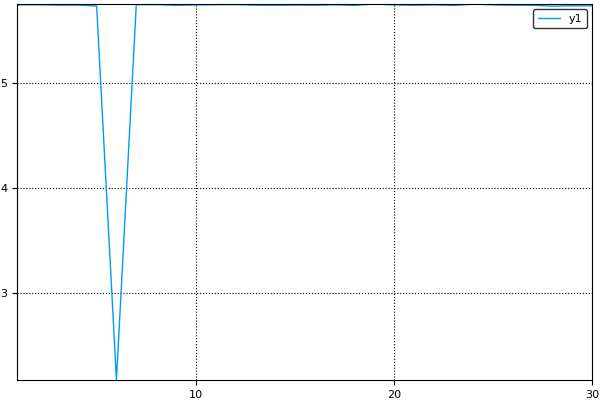

In [70]:
plot(losses)